In [31]:
!git clone https://github.com/iuryt/ttide_py.git && \
cd ttide_py && \
pip install . && \
cd ..

Cloning into 'ttide_py'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 565 (delta 18), reused 18 (delta 8), pack-reused 525
Receiving objects: 100% (565/565), 295.49 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (350/350), done.
Processing /content/drive/MyDrive/Shared/tide_prediction_luiscorreia/tide_prediction_luiscorreia/ttide_py
  Preparing metadata (setup.py) ... done
  Created wheel for ttide: filename=ttide-0.3.0-py3-none-any.whl size=34157 sha256=e510083c0c8f1cd04d5156e3fde1068a5e1dbe434da583ba40bbfd0cfa0dcdc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-pifmnrgf/wheels/10/42/5d/1ca8c1af2a92871a0d2aa5e55c7c5525821a307fd7affb4ab0
Successfully built ttide
  Attempting uninstall: ttide
    Found existing installation: ttide 0.3.0
    Uninstalling ttide-0.3.0:
      Successfully uninstalled ttide-0.3.0


In [73]:
!pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 5.2 MB/s eta 0:00:00


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import ttide as tt
import pandas as pd
import os
from glob import glob
from datetime import datetime
import numpy as np
import dateparser
import xarray as xr
import matplotlib.pyplot as plt

In [34]:
path = "/content/drive/MyDrive/Shared/tide_prediction_luiscorreia/tide_prediction_luiscorreia"
os.chdir(path)

In [35]:
fnames = glob("data/external/*")
fnames.sort()

fname_train, fname_test = fnames

In [43]:
dateparser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

kw = dict(
    header=11,
    sep=';',
    encoding='Latin-1',
    usecols = [0,1],
    names = ["tempo", "altura [cm]"],
    parse_dates = ["tempo"],
    date_parser = dateparser,
    index_col = "tempo"
)

train = pd.read_csv(fname_train, **kw).to_xarray()
display(train)

<xarray.Dataset>
Dimensions:      (tempo: 8783)
Coordinates:
  * tempo        (tempo) datetime64[ns] 1984-02-04T01:00:00 ... 1985-02-03T23...
Data variables:
    altura [cm]  (tempo) int64 109 142 204 263 311 338 ... 220 160 113 91 110

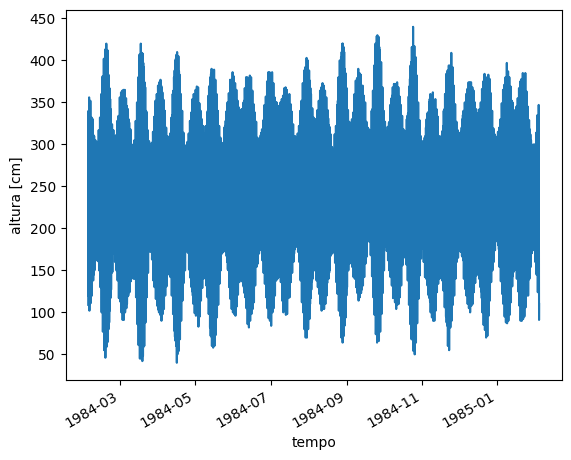

In [45]:
train["altura [cm]"].plot()

In [76]:
dt = (train.tempo.diff("tempo") / np.timedelta64(1, "h"))
mean, std = dt.mean().values, dt.std().values
stime = dateparser.parse(str(train.tempo.min().values))

print(f"Start time is {stime}, mean dt is {mean} hours and the std is {std} hours.")

Start time is 1984-02-04 01:00:00, mean dt is 1.0 hours and the std is 0.0 hours.


In [116]:
elev = train["altura [cm]"].values
t = ((train.tempo - train.tempo.min()) / np.timedelta64(1, "h")).values
tfit_e = tt.t_tide(elev, dt = mean)

-----------------------------------
nobs = 8783 
ngood = 8783 
record length (days) = 365.96
rayleigh criterion = 1.0

Phases at central time
x0= 238  xtrend= 0
var(data)= 6441.88    var(prediction)= 6383.71    var(residual)= 58.23
var(prediction)/var(data) (%) = 99.1

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     5.7851     3.303     44.90     22.65       3.1
  SSA   0.0002282     1.4982     2.201    337.69     91.21      0.46
  MSM   0.0013098     2.1720     2.366    311.43     76.50      0.84
  MM    0.0015122     0.4759     1.878    197.71    180.73     0.064
  MSF   0.0028219     1.5161     2.360    109.20    107.76      0.41
  MF    0.0030501     2.1804     2.637    255.53     80.09      0.68
  ALP1  0.0343966     0.0369     0.252      5.42    233.52     0.021
  2Q1   0.0357064     0.0763     0.246    209.74    222.25     0.096
  SIG1  0.0359087     0.2217     0.331     38.08     94

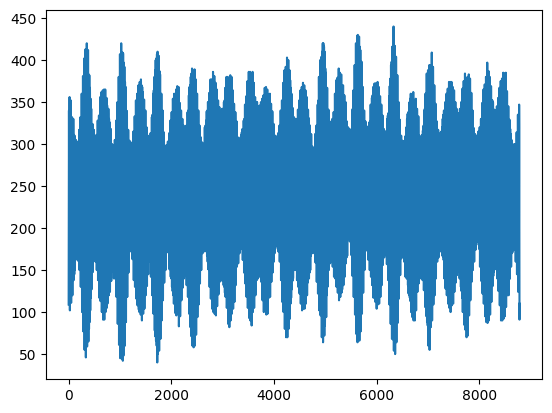

In [119]:
plt.plot(t, elev)

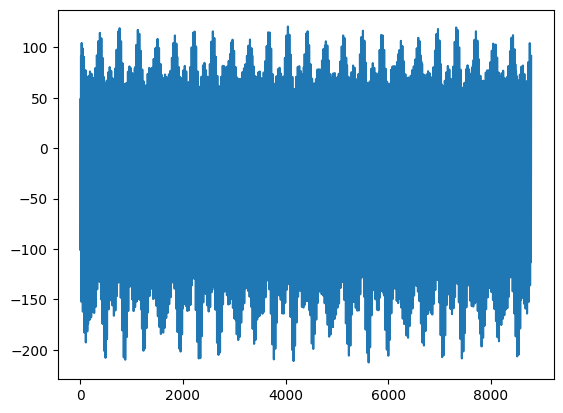

In [121]:
elev_fit = tfit_e(t)
plt.plot(t, elev_fit)

In [93]:
elev_fit = tfit_e(np.array(datetimes))

In [94]:
elev_fit

array([-131.67939742,  -92.07161228,  -32.17760694, ..., -120.51612572,
       -138.36020413, -121.02906008])

In [107]:
fit = tfit_e(((train.tempo - train.tempo.min()) / np.timedelta64(1, "h")).values)
train = train.assign(fit = ("tempo", fit))

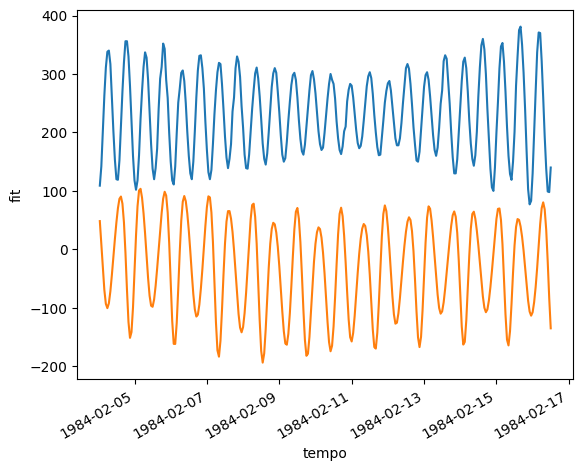

In [114]:
train["altura [cm]"].isel(tempo = slice(0, 300)).plot()
train.fit.isel(tempo = slice(0, 300)).plot()

-----------------------------------
nobs = 1001 
ngood = 1001 
record length (days) = 41.71
rayleigh criterion = 1.0

Phases at central time
x0= 3.66e-06  xtrend= 0
var(data)= 12.53    var(prediction)= 12.53    var(residual)= 0.00
var(prediction)/var(data) (%) = 100.0

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  MM    0.0015122     0.0004     0.000     89.79     62.58       1.3
  MSF   0.0028219     0.0001     0.000    266.87    146.24      0.16
  ALP1  0.0343966     0.0004     0.000    269.34     65.68       1.7
* 2Q1   0.0357064     0.0004     0.000     88.36     49.59         2
  Q1    0.0372185     0.0003     0.000     89.82     79.73      0.79
  O1    0.0387307     0.0004     0.000    268.05     52.61       1.7
  NO1   0.0402686     0.0004     0.000    269.19     55.97       1.8
  K1    0.0417807     0.0004     0.000     87.64     54.23         1
* J1    0.0432929     0.0005     0.000     88.85     51

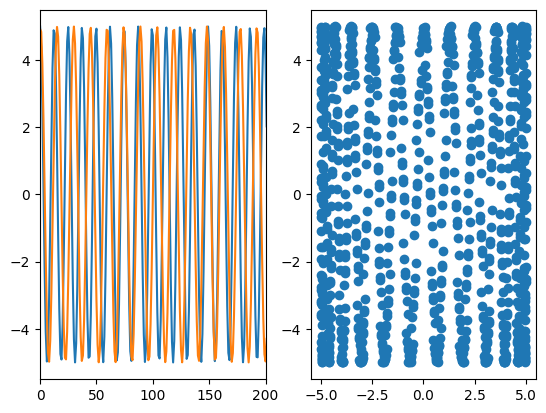

In [130]:
import ttide as tt
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(1001)
m2_freq = 2 * np.pi / 12.42

elev = 5 * np.cos(m2_freq * t)

tfit_e = tt.t_tide(elev)

elev_fit = tfit_e(t)

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, elev)
ax[0].plot(t, elev_fit)
ax[0].set(xlim = [0, 200])
ax[1].scatter(elev, elev_fit)